In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics, linear_model
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict
import cmath
import random

import deepchem as dc

import tensorflow as tf
from tensorflow import keras

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

from sklearn.exceptions import DataConversionWarning
import warnings
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

%matplotlib inline
sns.set()

correlation_selected = pd.read_csv("qsar_correlation_processed.csv")
data = pd.read_csv("qsar_lasso_processed.csv")
              

### Use stratified dataset split to ensure equal distribution of logRA values across set

The histogram plots show a roughly equal distribution of log RA values across the different splits. The plots also show that the log RA values are not normally distributed throughout the data set. In particular, there are several molecules (~20) that have the same log RA value of -4. Data analysis showed that these molecules are structurally diverse, with different values for the global moleculear descriptors. Consequently, these samples might be outliers, or indeed the feature set of molecular descriptors is insufficient to accuratly describe molecules with the same log RA values. 

(136, 61) (136, 1)
(17, 61) (17, 1)
(17, 61) (17, 1)


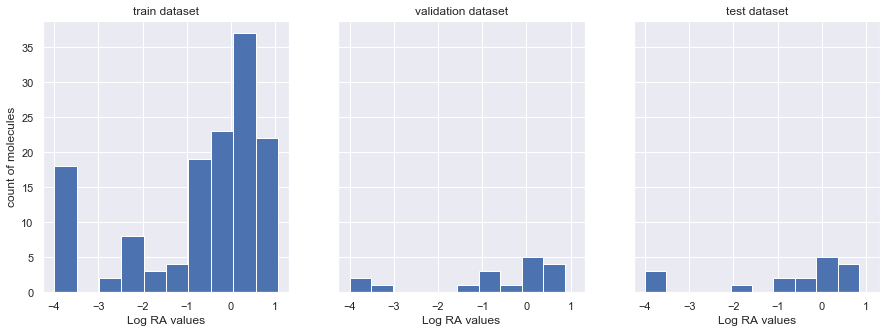

In [42]:
# Feature set should include all columns except for the label y 
y = np.array(data['y_var']).reshape(-1,1)
X = np.array(data.drop('y_var', axis=1))


def train_valid_test_split(y, frac_train=0.8, frac_valid=0.1, frac_test=0.1, seed=None):
    if not seed is None:
        np.random.seed(seed)
    split_cd = 10
    train_cutoff = int(np.round(frac_train * split_cd))
    valid_cutoff = int(np.round(frac_valid * split_cd)) + train_cutoff
    test_cutoff = int(np.round(frac_test * split_cd)) + valid_cutoff

    train_idx = np.array([], dtype=int)
    valid_idx = np.array([], dtype=int)
    test_idx = np.array([], dtype=int)
    
    sortidx = np.argsort(y)
    
    i = 0
    while sortidx.shape[0] >= split_cd:
        #print("split iteration: ", i, "remaining data:", sortidx.shape[0])
        old = split_cd * i
        i +=1
        new = split_cd * i
        sortidx_split, sortidx = np.split(sortidx, [split_cd])
        shuffled = np.random.permutation(range(old, new))
        train_idx = np.hstack([train_idx, sortidx_split[shuffled[:train_cutoff]]])
        valid_idx = np.hstack(
          [valid_idx, sortidx_split[shuffled[train_cutoff:valid_cutoff]]])
        test_idx = np.hstack([test_idx, sortidx_split[shuffled[valid_cutoff:]]])

    # Append remaining examples to train
    if sortidx.shape[0] > 0: np.hstack([train_idx, sortidx])
    
    return train_idx, valid_idx, test_idx
    
train_idx, valid_idx, test_idx = train_valid_test_split(data['y_var'])
 
# Apply split

X_train, y_train = (np.array(X[train_idx]), np.array(y[train_idx]))
X_valid, y_valid = (np.array(X[valid_idx]), np.array(y[valid_idx]))
X_test, y_test = (np.array(X[test_idx]), np.array(y[test_idx]))

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)


# Distribution of Log RA values across data splits

fix, ax = plt.subplots(1,3,figsize=(15,5), sharex=True, sharey=True)
ax[0].hist(y_train)
plt.title("Histogram of Log RA values")
ax[0].set_title("train dataset")
ax[0].set_xlabel("Log RA values")
ax[0].set_ylabel("count of molecules")
ax[1].hist(y_valid)
ax[1].set_title("validation dataset")
ax[1].set_xlabel("Log RA values")
ax[2].hist(y_test)
ax[2].set_title("test dataset")
ax[2].set_xlabel("Log RA values")
# plt.ylabel("number of molecules")
#plt.title("Histogram of atomisation energies")
plt.show()

optimal alpha chosen by CV on 3 folds:  10.0
R2 Score : 0.436668008032201


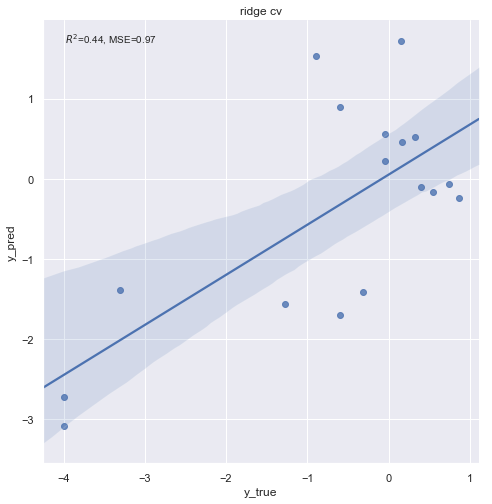

In [43]:
## Preprocessing 

# Normalisation scaling

scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

## Model testing with cross-validation 
#linear = linear_model.LinearRegression()
ridgecv = linear_model.RidgeCV(cv=3, alphas=[1e-2, 1e-1, 1, 10]).fit(X_train_scaled, y_train)

print("optimal alpha chosen by CV on 3 folds: ", ridgecv.alpha_)
print("R2 Score :", ridgecv.score(X_valid_scaled, y_valid))


# Bar chart of estimated coefficients 
coefficients = ridgecv.coef_

pred = ridgecv.predict(X_valid_scaled)
pred_df = pd.DataFrame(pred, columns=['y_pred'])
pred_df['y_true'] = y_valid
sns.pairplot(pred_df, x_vars='y_true', y_vars='y_pred', height=7, aspect=1, kind='reg')
plt.title("ridge cv")
plt.annotate('$R^2$=%.2f, MSE=%.2f' % (metrics.r2_score(y_valid, pred), metrics.mean_absolute_error(y_valid, pred)), xy=(0.05, 0.95), xycoords='axes fraction')
plt.show()


Average MAE for ridge regression model: 1.240 (+/- -0.843)
Average MSE for ridge regression model: 2.914 (+/- -3.203)
Average R2 for ridge regression model: -6.970 (+/- 4.762)


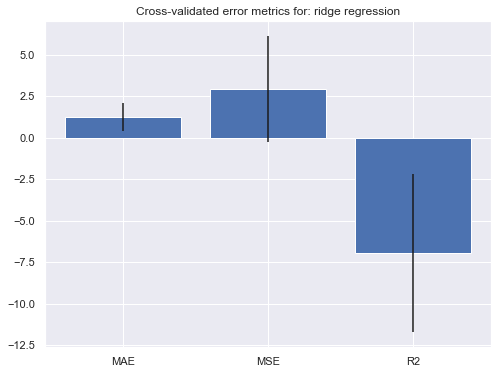

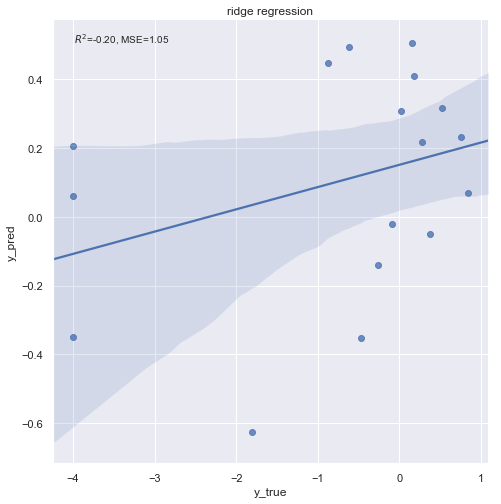

/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in sqrt


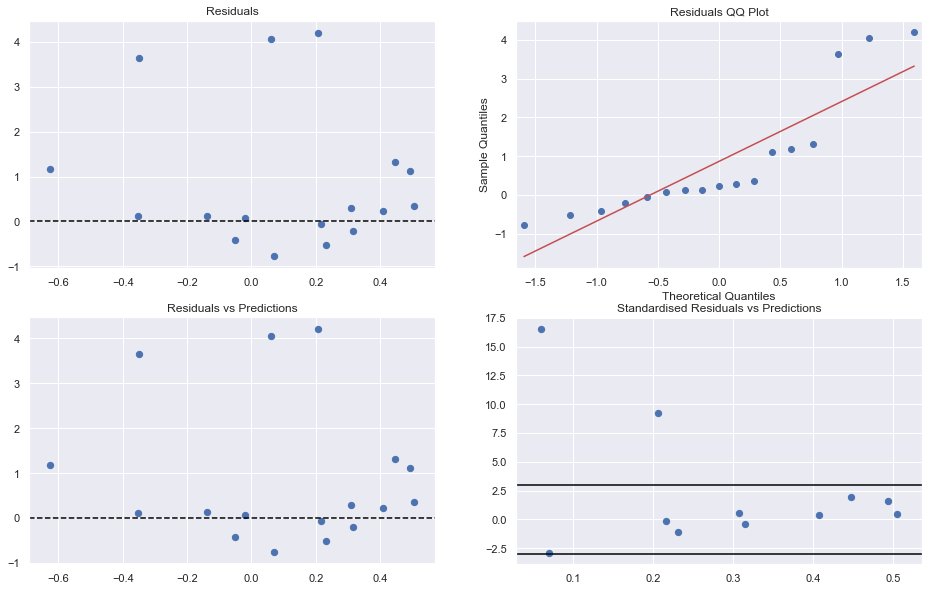

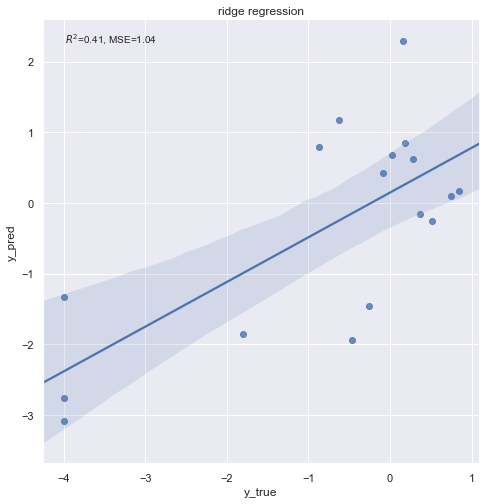

/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in sqrt


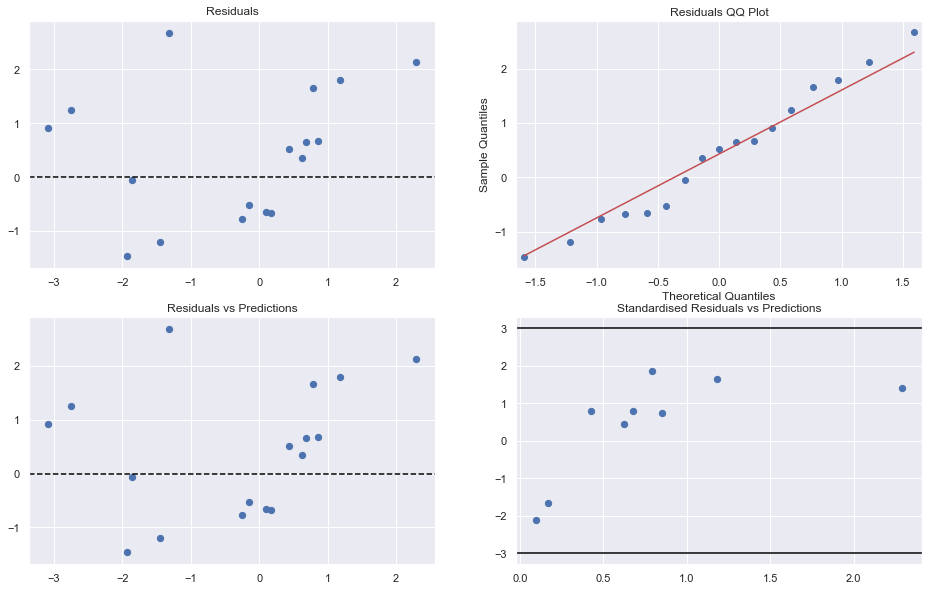

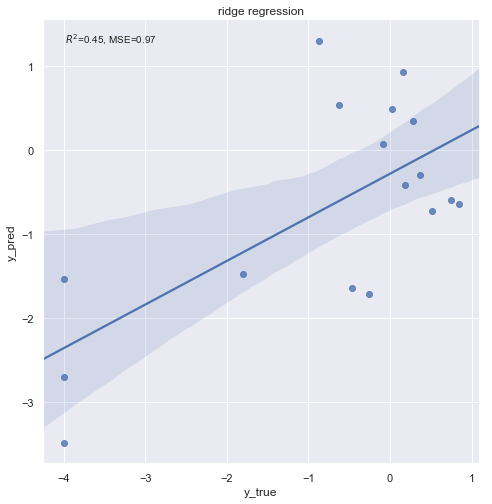

/Users/nathalie.willems/anaconda3/envs/deepchem/lib/python3.5/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in sqrt


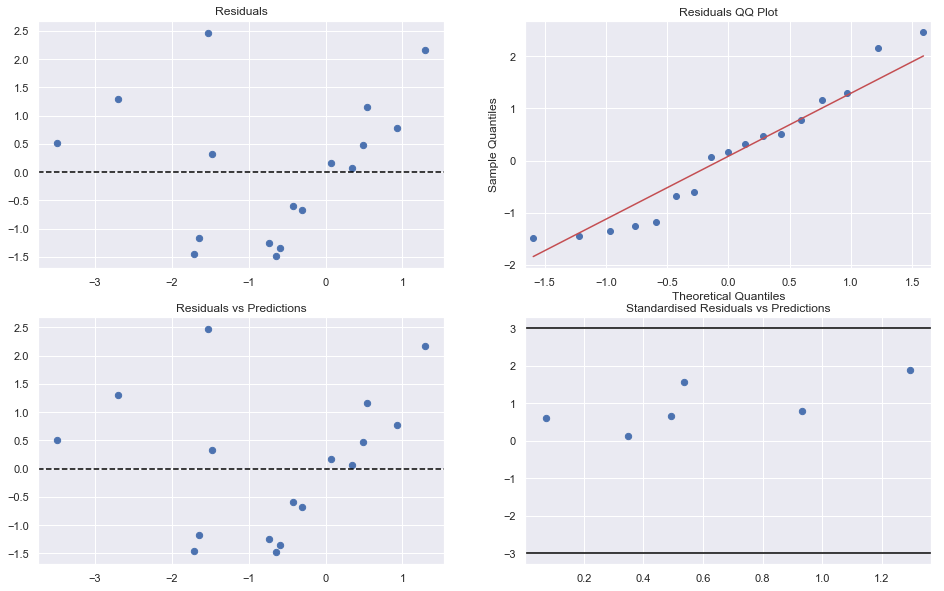

best model: 2 r2 score: 0.45
Average MAE for random forest regression model: 1.429 (+/- -0.915)
Average MSE for random forest regression model: 3.625 (+/- -3.708)
Average R2 for random forest regression model: -10.910 (+/- 8.457)


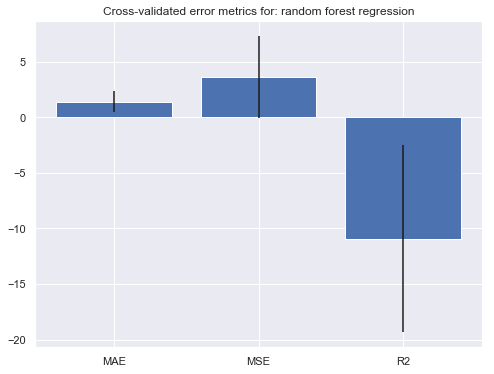

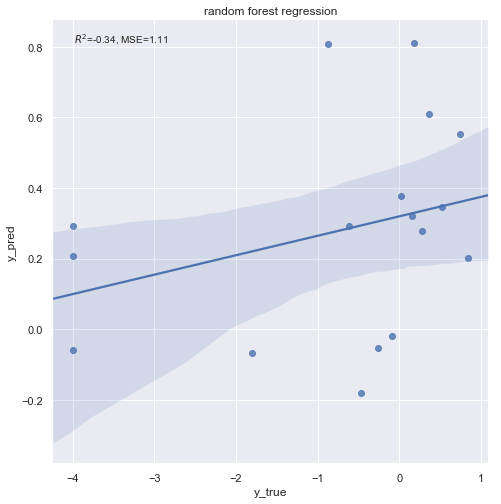

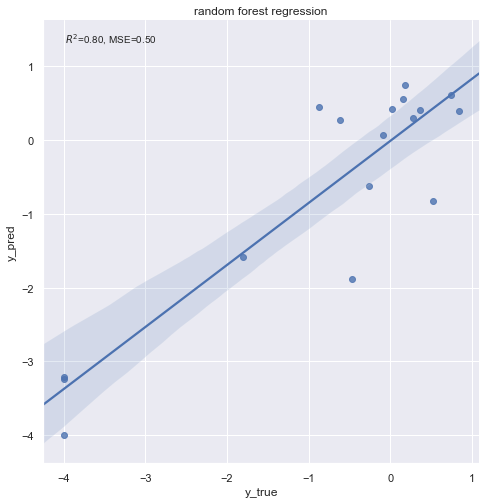

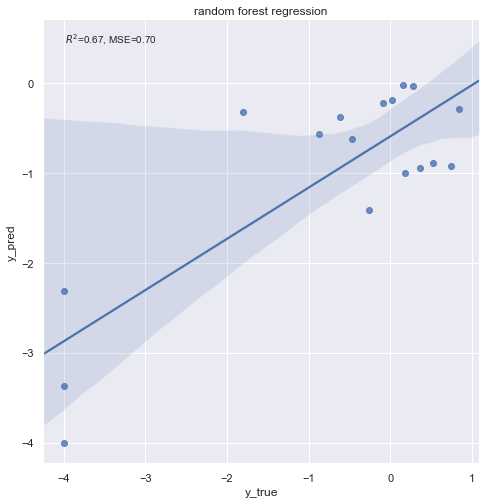

best model: 2 r2 score: 0.80


In [44]:

rf = RandomForestRegressor()
ridge = linear_model.Ridge(alpha=10)
## Scoring metrics
metric = ['neg_mean_absolute_error','neg_mean_squared_error', 'r2']

def fit_model(X, y, model, model_name):
    #clf = make_pipeline(scaler, model)
    scores = cross_validate(model, X, y, cv=3, scoring=metric, return_train_score=False, return_estimator=True)
    names = ['MAE', 'MSE', 'R2']
    stats = {}
    stats[model_name] = {'means': [-1 * scores['test_neg_mean_absolute_error'].mean(), 
                                    -1 * scores['test_neg_mean_squared_error'].mean(), 
                                    scores['test_r2'].mean()],
                        'stds': [ -1 * scores['test_neg_mean_absolute_error'].std(),
                                   -1 * scores['test_neg_mean_squared_error'].std(),
                                   scores['test_r2'].std()]}
    print("Average MAE for %s model: %0.3f (+/- %0.3f)" % (model_name, stats[model_name]['means'][0], 
                                                           stats[model_name]['stds'][0]))
    print("Average MSE for %s model: %0.3f (+/- %0.3f)" % (model_name, stats[model_name]['means'][1], 
                                                           stats[model_name]['stds'][1]))
    print("Average R2 for %s model: %0.3f (+/- %0.3f)" % (model_name, stats[model_name]['means'][2], 
                                                          stats[model_name]['stds'][2]))
    # ## Error metric plots
    plt.figure(figsize=(8,6))
    plt.title("Cross-validated error metrics for: %s" % model_name)
    plt.bar(names, stats[model_name]['means'], yerr=stats[model_name]['stds'])
    plt.show()
    return scores

def residual_plots(y, pred):
    residuals = pred - y
    standardised_residuals = residuals / np.sqrt(pred)
    fig, ax = plt.subplots(2,2, figsize=(16,10))
    #print("shape y: ", y.shape, "pred shape: ", pred.shape)
    ax[0,0].scatter(x=pred, y=residuals, s=40)
    ax[0,0].axhline(y=0, c='black',linestyle='--')
    ax[0,0].set_title("Residuals")
    sm.qqplot(residuals, line='s', ax=ax[0,1])
    ax[0,1].set_title("Residuals QQ Plot")
    ax[1,0].scatter(pred, residuals, s=40)
    ax[1,0].axhline(y=0, c='black', linestyle='--')
    ax[1,0].set_title("Residuals vs Predictions")
    ax[1,1].scatter(pred,standardised_residuals, s=40)
    ax[1,1].set_title("Standardised Residuals vs Predictions")
    ax[1,1].axhline(y=3, c='black')
    ax[1,1].axhline(y=-3, c='black')
    plt.show()
    
def evaluate_models(scores, X, y, name):
    best_r2 = 0
    best_mae = 0
    best_model = None
    for i in range(len(scores['estimator'])):
        model = scores['estimator'][i]
        pred = model.predict(X)
        pred_df = pd.DataFrame(pred, columns=['y_pred'])
        pred_df['y_true'] = y_test
        sns.pairplot(pred_df, x_vars='y_true', y_vars='y_pred', height=7, aspect=1, kind='reg')
        plt.title(name)
        plt.annotate('$R^2$=%.2f, MSE=%.2f' % (metrics.r2_score(y, pred), metrics.mean_absolute_error(y, pred)), xy=(0.05, 0.95), xycoords='axes fraction')
        plt.show()
        r2 = metrics.r2_score(y, pred)
        if name == 'linear regression' or name == 'ridge regression':
            residual_plots(pred_df['y_true'], pred_df['y_pred'])
        if r2 > best_r2:
            best_r2  = r2
            best_model = model
    print("best model: %s r2 score: %0.2f" % (i, best_r2))
    return best_model


# lin_scores = fit_model(X_train, y_train, linear, 'linear regression')
# lin_best = evaluate_models(lin_scores, X_valid, y_valid, 'linear regression')

ridge_scores = fit_model(X_train_scaled, y_train, ridge, 'ridge regression')
ridge_best = evaluate_models(ridge_scores, X_valid_scaled, y_valid, 'ridge regression')

rf_scores = fit_model(X_train_scaled, y_train, rf, 'random forest regression')
rf_best = evaluate_models(rf_scores, X_valid_scaled, y_valid, 'random forest regression')


## Random Forest Model Analysis

[1.00051369e-03 1.40816959e-05 0.00000000e+00 4.94581450e-03
 8.51550195e-04 5.04777520e-06 0.00000000e+00 4.96936817e-03
 0.00000000e+00 1.70705463e-02]


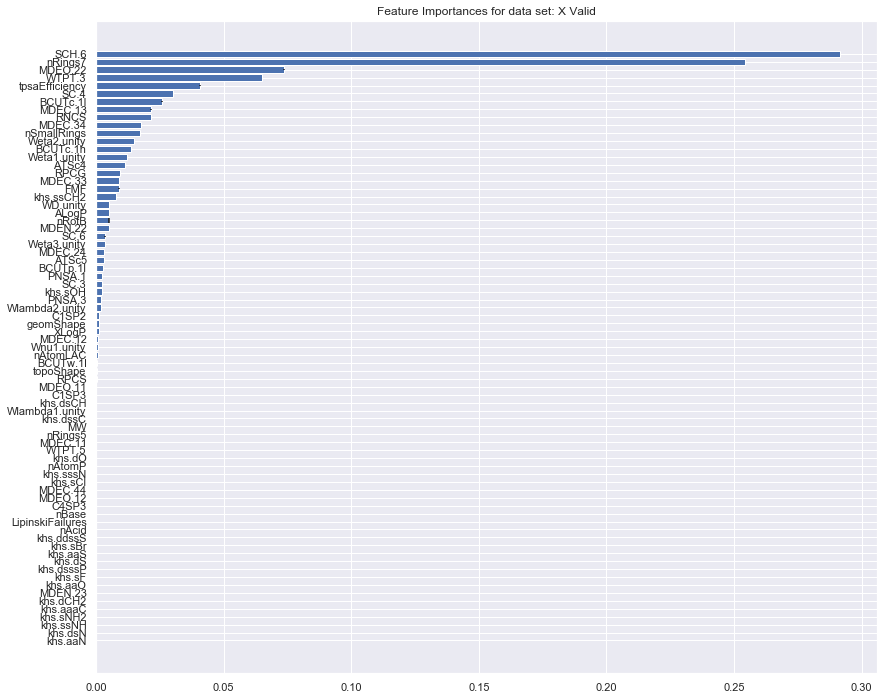

In [134]:
## Feature importance 

def rf_feature_importance(data, model, X, name):
    n_col = data.shape[1]
    features = data.columns[0:n_col]
    pred = model.predict(X)
    #m=RandomForestRegressor(n_estimators=50, oob_score=True,n_jobs=-1,bootstrap=True,random_state=42)
    rank = model.feature_importances_
    indices = np.argsort(model.feature_importances_)
    #print(indices[:10])
    top = rank[indices][:10]
    print(rank[:10])
    std = np.std([tree.feature_importances_ for tree in model.estimators_],axis=0)
    plt.figure(figsize=(14,12))
    plt.barh(range(len(indices)), rank[indices], align='center', yerr=std)
    plt.yticks(range(len(indices)), features[indices])
    plt.title('Feature Importances for data set: %s' % name)
    return rank, indices
    
df = pd.DataFrame(data)
rank, indices = rf_feature_importance(df, rf_best, X_valid, "X Valid")
#print("ranked: %s" % (rank[indices][:10]))

In [135]:
rf_best.get_params().keys()

dict_keys(['oob_score', 'min_impurity_split', 'min_samples_leaf', 'bootstrap', 'min_samples_split', 'criterion', 'max_features', 'n_estimators', 'min_weight_fraction_leaf', 'min_impurity_decrease', 'max_depth', 'random_state', 'max_leaf_nodes', 'verbose', 'n_jobs', 'warm_start'])

In [136]:
from sklearn.model_selection import GridSearchCV

## Grid search of RF model parameters

## Random Forest parameters
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [4,5,6,7, 8]

}

# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_r2'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_r2'][candidate],
                  results['std_test_r2'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

# Define scoring metrics

metric = ['neg_mean_squared_error', 'r2']

# Create a regressor object with the regressor and parameter candidates
clf = GridSearchCV(estimator=rf_best, param_grid=param_grid, n_jobs=-1, cv=3, iid=False, scoring=metric, refit='r2')

# Train the classifier on data1's feature and target data
clf.fit(X_train, y_train)
non_nested_scores = clf.best_score_

# Nested CV with parameter optimization
nested_scores = cross_val_score(clf, X=X_train, y=y_train, cv=3, scoring='r2')
score_difference = non_nested_scores - nested_scores

results = clf.cv_results_
#%%
print("Best parameters set found on training set:")
print()
print(report(results))
print()
print("nested scores: ", nested_scores)
print("non_nested_scores: ", non_nested_scores)
print("score difference: ", score_difference)

Best parameters set found on training set:

Model with rank: 1
Mean validation score: -9.175 (std: 8.627)
Parameters: {'n_estimators': 100, 'max_features': 'auto', 'max_depth': 7}

Model with rank: 2
Mean validation score: -9.349 (std: 9.248)
Parameters: {'n_estimators': 300, 'max_features': 'auto', 'max_depth': 4}

Model with rank: 3
Mean validation score: -9.351 (std: 9.176)
Parameters: {'n_estimators': 100, 'max_features': 'auto', 'max_depth': 4}

None

nested scores:  [ -3.75790536  -2.5274015  -22.83495842]
non_nested_scores:  -9.17475452783947
score difference:  [-5.41684916 -6.64735303 13.66020389]


## Neural Network Models

### !! This section is not complete and needs more development/testing!!


In [39]:
# Initial hyperparameters were inspired by 
# "Development of QSAR models to predict and interpret the biological activity of artemisinin analogues"

# Best architecture: 10-5-1
# Sigmoid activation function 

def build_model_1(activation):
    model = tf.keras.Sequential([
    keras.layers.Dense(10, activation=activation, input_shape=(61,)),
    keras.layers.Dense(5, activation=activation),
    keras.layers.Dense(1)])
    # Configure a model for mean-squared error regression.
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    #optimizer = tf.keras.optimizers.SGD(0.01)
    #optimizer = tf.keras.optimizers.Adam(0.01)
    model.compile(optimizer=optimizer,
                  loss='mse',       # mean squared error
                  metrics=['mae', 'mse'])  # mean absolute error
    return model

def build_model_2(activation):
    model = tf.keras.Sequential([
    # Adds a densely-connected layer with 10 units to the model:
    keras.layers.Dense(30, activation=activation, input_shape=(61,)),
    keras.layers.Dense(30, activation=activation),
    keras.layers.Dense(1)])
    # Configure a model for mean-squared error regression.
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    #optimizer = tf.keras.optimizers.SGD(0.01)
    #optimizer = tf.keras.optimizers.Adam(0.01)
    model.compile(optimizer=optimizer,
                  loss='mse',       # mean squared error
                  metrics=['mae', 'mse'])  # mean absolute error
    return model

def plot_history(history, title):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    fig, ax = plt.subplots(1,2, figsize=(12,6))
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Mean Abs Error')
    ax[0].plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
    ax[0].plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
    ax[0].set_title(title)
    #plt.ylim([0,5])
    ax[0].legend()
    
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Mean Square Error')
    ax[1].plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
    ax[1].plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
    #plt.ylim([0,20])
    ax[1].set_title(title)
    ax[1].legend()
    plt.show()

def fit_model(activations, model_func, X_train, y_train):
    models = {}
    for act in activations:
        print("activation function: %s, model type: " % act)
        keras_model = model_func(act)

        # The patience parameter is the amount of epochs to check for improvement
        early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)

        history = keras_model.fit(X_train, y_train, validation_split = 0.2, epochs=100, 
                            callbacks=[early_stop], batch_size=10, verbose=0)

        models[act] = keras_model
        plot_history(history, act)
        
        # Test
        loss, mae, mse = keras_model.evaluate(X_test_scaled, y_test, verbose=0)

        print("Testing set Mean Abs Error: {:5.2f} -Log RA".format(mae))
#         hist = pd.DataFrame(history.history)
#         hist['epoch'] = history.epoch
#         hist.tail()
    return models
    
def model_predict(model, X_test, y_test):
    # Predict
    predictions = model.predict(X_test)

    pred_scores = model.evaluate(X_test, y_test)
    print('Test loss:', pred_scores[0])
    print('Test accuracy:', pred_scores[1])

    results = pd.DataFrame(predictions, columns = ['y_pred'])
    #print(results, y_test)
    #results.columns = ['y_pred']
    results['y_true'] = y_test.reset_index()['y_var']
    sns.pairplot(results, x_vars='y_true', y_vars='y_pred', height=7, aspect=1, kind='reg')
    plt.title("Neural network model")
    plt.annotate('$R^2$=%.2f, MSE=%.2f' % (metrics.r2_score(y_test, predictions), metrics.mean_absolute_error(y_test, predictions)), xy=(0.05, 0.95), xycoords='axes fraction')
    plt.show()

    print("prediction dataframe: \n", results.head(4))
    error = abs(results['y_true'] - results['y_pred'])
    plt.figure(figsize=(8,6))
    plt.hist(error, bins=5)
    plt.xlabel("Prediction Error")
    _ = plt.ylabel("Count")
    plt.show()

---------------
Model 1: 10-5-1
---------------
activation function: sigmoid, model type: 


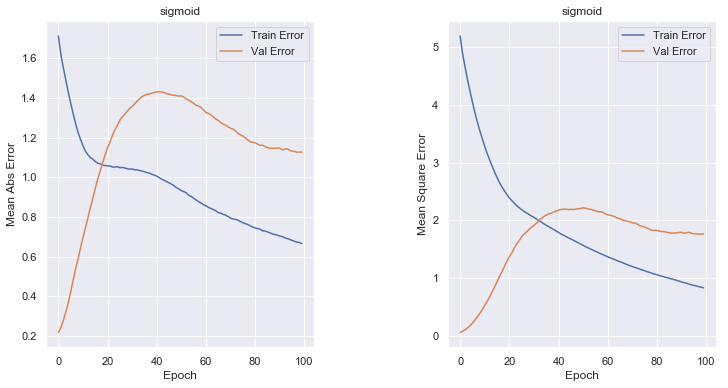

Testing set Mean Abs Error:  0.98 -Log RA
activation function: relu, model type: 


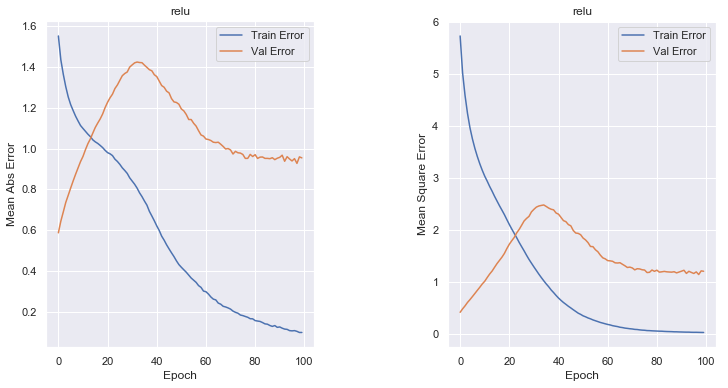

Testing set Mean Abs Error:  0.65 -Log RA
---------------
Model 2: 30-30-1
---------------
activation function: sigmoid, model type: 


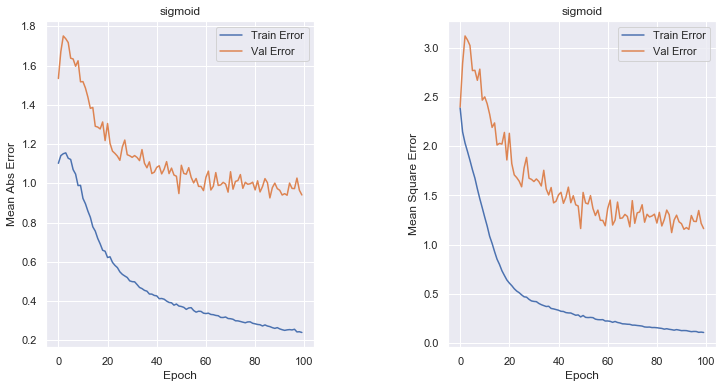

Testing set Mean Abs Error:  0.70 -Log RA
activation function: relu, model type: 


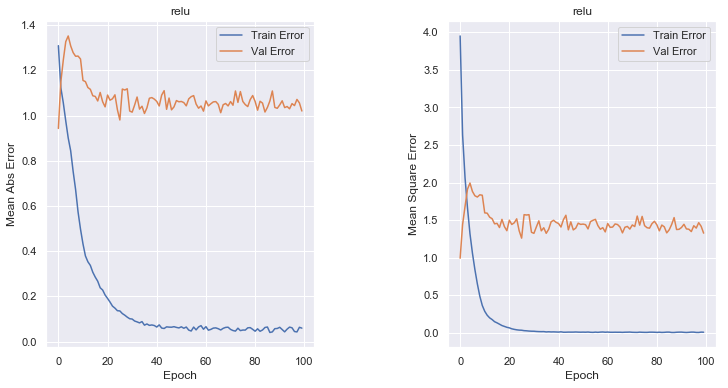

Testing set Mean Abs Error:  0.84 -Log RA


In [40]:
activation_functions = ['sigmoid', 'relu']


print("---------------")
print("Model 1: 10-5-1")
print("---------------")
models_1 = fit_model(activation_functions, build_model_1, X_train_scaled, y_train)
print("---------------")
print("Model 2: 30-30-1")
print("---------------")
models_2 = fit_model(activation_functions, build_model_2, X_train_scaled, y_train)

---Prediction----
36/36 [==============================] - 0s 72us/sample - loss: 1.6942 - mean_absolute_error: 0.9970 - mean_squared_error: 1.6942
Test loss: 1.6941644847393036
Test accuracy: 0.99701107


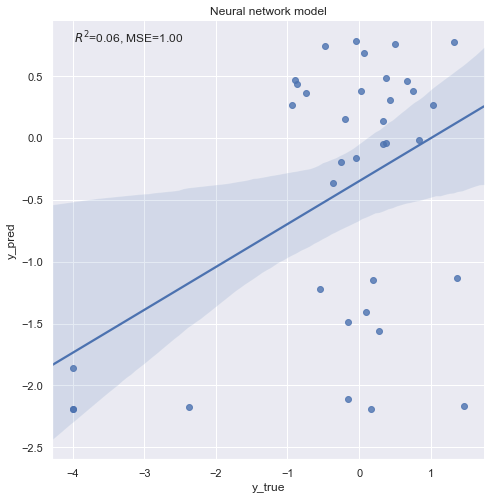

prediction dataframe: 
      y_pred  y_true
0 -1.223621   -0.55
1 -1.405894    0.10
2  0.774398    1.32
3  0.381029    0.02


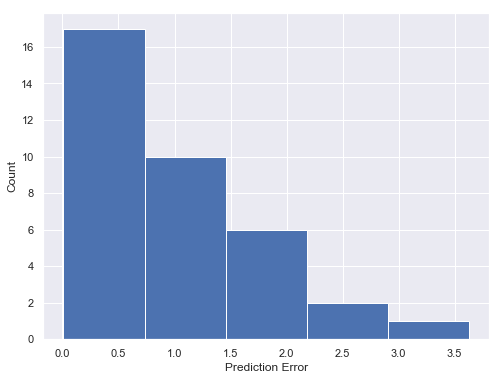

36/36 [==============================] - 0s 59us/sample - loss: 1.1266 - mean_absolute_error: 0.7672 - mean_squared_error: 1.1266
Test loss: 1.1265912983152602
Test accuracy: 0.7672243


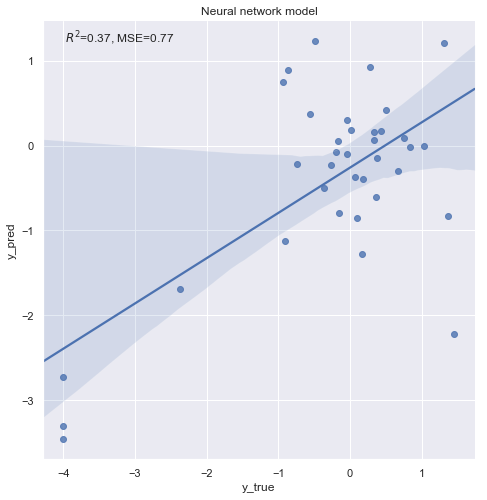

prediction dataframe: 
      y_pred  y_true
0  0.371082   -0.55
1 -0.855063    0.10
2  1.208614    1.32
3  0.185147    0.02


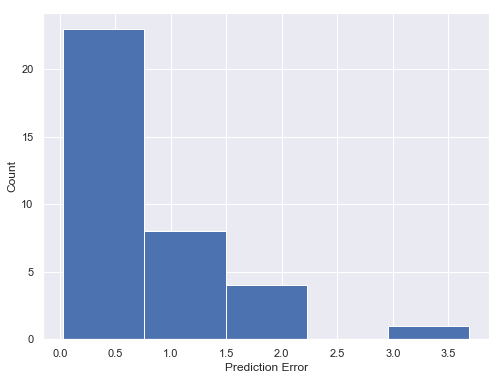

In [25]:
print("---Prediction----")

for m in models_1:
    #print(models[m])
    model_predict(models_1[m], X_test_scaled, y_test)

In [27]:
example_batch = X_train_scaled[:10]
example_result = models_1['sigmoid'].predict(example_batch)
example_result

array([[-1.6937764 ],
       [-1.4271785 ],
       [ 0.14019111],
       [-2.0600002 ],
       [-2.0043669 ],
       [-0.06624839],
       [ 0.05327615],
       [ 0.14529395],
       [-2.0459526 ],
       [ 0.2721492 ]], dtype=float32)